# ICESat-2 sea ice tutorial


## 	&#x2B50; Objectives
- Learn how to access/download ICESat-2 sea ice products (ATL07/ATL10/ATL20) via `icepyx` or `earthaccess` libraries.
- Examine what the ICESat-2 sea ice freeboard products (ATL10/ATL20) look like.
- Derive sea ice properties (sea ice thickness, floe size distribution, lead fraction) using ATL10 product.
- Map monthly sea ice freeboard using ATL20 product.

## &#x1F4CC; What is sea ice?
```{figure} https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Sea_ice_Drawing_General_features.svg/1920px-Sea_ice_Drawing_General_features.svg.png
:name: sea ice diagram

Schematic diagram of common sea-ice related features.
```

Sea ice is frozen seawater that floats on the ocean surface. It forms in both the Arctic and the Antarctic in each hemisphere’s winter; it retreats in the summer, but does not completely disappear. Sea ice is not just a "flat" surface. Sea ice surface is very dynamic, so sea ice surface consists of various topograhic features, such as ridges (occur when sea ice floes collide) or leads (open water or thin ice space between sea ice floes). The fine resolution of ICESat-2 allows us to detect the details of these sea ice dynamic features.

## &#x1F4CC; How can laser altimeters measure sea ice freeboard/thickness?

```{figure} https://www.mdpi.com/remotesensing/remotesensing-14-01069/article_deploy/html/images/remotesensing-14-01069-g004-550.jpg
:name: sea ice freeboard and thickness

Schematic diagram of sea ice height and sea ice freeboard (source: [Pang et al. 2022](https://www.mdpi.com/2072-4292/14/5/1069))
```


Sea ice freeboard means the height of sea ice surface above **local sea surface**. To calculate sea ice freeboard, it is necessary to subtract local sea surface height from the sea ice height.

$H_{f} = H_{obs} - H_{ssh}$

The **ATL07** product provides the surface height above the reference ellipsoid (WGS84). The ATL07 product aggregates 150 signal photons as a single "height segment", and the mean height of this segment is determined as the surface height. In general, each height segment has 10-20 m of length (strong beams).

Then, in order to calculate sea ice freeboard, it is necessary to separate the height signal from **open water (lead)** and **sea ice surface**. The ATL07 product has its own algorithm to distinguish leads from sea ice. There are two types of leads detected by the ATL07: specular lead (high photon rate/reflectance) and dark lead (low photon rate/reflectance).


```{figure} https://agupubs.onlinelibrary.wiley.com/cms/asset/3c1371bd-2e8e-4948-8b83-e348cbed6bb0/ess2761-fig-0002-m.jpg
:name: ATL07 lead detection

Example of ATL07 profile and surface classification with overlapped optical image (source: [Petty et al. 2022](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020EA001491))
```


The **ATL10** product calculates the height difference between sea ice surface and lead surface. The local sea level ($H_{ssh}$) is calculated for every 10 km using detected leads.

## &#x1F4CC; ICESat-2 sea ice products
- <b> ATL07 </b> (sea ice surface heights): Surface height relative to WGS84 ellipsoid. Derived by aggregating 150 signal photons of the ATL03 product. 
- <b> ATL10 </b> (freeboard): Sea ice freeboard calculated from ATL07 product.
- <b> ATL20 </b> (daily/monthly gridded sea ice freeboard): 25-km gridded mean freeboard in daily/monthly scale.


```{figure} https://nsidc.org/sites/default/files/images/Data/ICESat2_DataProducts_2023.png
:name: ICESat-2 sea ice products

ICESat-2 products (source: [NSIDC](https://nsidc.org/data/icesat-2/products))
```

## &#x2705; Access & Download sea ice products (1) - Use icepyx

In this tutorial, first, we will use `icepyx` library to access or download ICESat-2 datasets.

In [18]:
import warnings
warnings.filterwarnings('ignore')
import glob, os
from datetime import datetime, timedelta
# import icepyx as ipx
import earthaccess
import geopandas as gpd

In [2]:
import ee
import geemap
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

In [3]:
import h5py
import pyproj

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import cartopy.crs as ccrs

%matplotlib inline
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import pandas as pd

## Function to read ATL10 data
def read_atl10(filename, spatial_extent):

    # Create a list for saving ATL10 beam track data
    track = []

    with h5py.File(filename,'r') as f:

        # Check the orbit orientation
        orient = f['orbit_info/sc_orient'][0]

        if orient == 0:
            strong_beams = [f"gt{i}l" for i in [1, 2, 3]]
        elif orient == 1:
            strong_beams = [f"gt{i}r" for i in [1, 2, 3]]
        else:
            strong_beams = []

        for beam in strong_beams:
            # Version 5
            lat = f[beam]['freeboard_beam_segment/beam_freeboard/latitude'][:]
            lon = f[beam]['freeboard_beam_segment/beam_freeboard/longitude'][:]
            seg_x = f[beam]['freeboard_beam_segment/beam_freeboard/seg_dist_x'][:] / 1000 # (m to km)
            seg_len = f[beam]['freeboard_beam_segment/height_segments/height_segment_length_seg'][:]
            fb = f[beam]['freeboard_beam_segment/beam_freeboard/beam_fb_height'][:]
            surface_type = f[beam]['freeboard_beam_segment/height_segments/height_segment_type'][:]
            
            # lat = f[beam]['freeboard_segment/latitude'][:]
            # lon = f[beam]['freeboard_segment/longitude'][:]
            # seg_x = f[beam]['freeboard_segment/seg_dist_x'][:] / 1000 # (m to km)
            # seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][:]
            # fb = f[beam]['freeboard_segment/beam_fb_height'][:]
            # surface_type = f[beam]['freeboard_segment/heights/height_segment_type'][:]
            fb[fb>100] = np.nan

            df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len,
                              'freeboard': fb, 'stype': surface_type})

            df = df[(df['lat'] > spatial_extent[1]) & (df['lat'] < spatial_extent[3])].reset_index(drop=True)

            df['beam'] = beam
            df = df.dropna().reset_index(drop = True)

            track.append(df)
            
    return track

In [4]:
# Data product: ATL10 (sea ice freeboard)
short_name = 'ATL10'

# Spatial extent: Ross Sea, Antarctica
spatial_extent = [170, -78, -170, -70]

# Time range
date_range = ['2019-09-10','2019-09-16'] # first time period
# date_range = ['2019-11-13','2019-11-13'] # second time period

## &#x2705; Access & Download sea ice products (2) - Use Earthaccess

There is another way to access ICESat-2 data using another Python library `Earthaccess`. In the following Earthaccess example, you can access the raw ICESat-2 data remotely without downloading them to your local machine.

In [34]:
auth = earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in C:\Users\yok223


Enter your Earthdata Login username:  younghyunkoo
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 09/11/2023
Using user provided credentials for EDL


In [29]:
date_range = ['2019-09-05 T00:00:00','2019-09-05 T23:59:59'] 
bb = [170, -78, -170, -70]

Query = earthaccess.granule_query().concept_id(
    'C2153574813-NSIDC_CPRD'
).temporal(date_range[0], date_range[1]
).bounding_box(bb[0], bb[1], bb[2], bb[3])

# Bounding box: [West lon, South lat, East lon, North lat]
# ATL07: C2153574585-NSIDC_CPRD
# ATL10: C2153574813-NSIDC_CPRD
# ATL20: C2153577387-NSIDC_CPRD

In [30]:
Query.hits()

3

In [31]:
granules = Query.get()
[display(g) for g in granules];

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Freeboard V005'}
Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': 15.96246588204698, 'StartLatitude': -27.0, 'StartDirection': 'D', 'EndLatitude': -27.0, 'EndDirection': 'A'}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2019-09-05T00:01:34.213Z', 'EndingDateTime': '2019-09-05T00:17:18.288Z'}}
Size(MB): 76.46118259429932
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL10/005/2019/09/05/ATL10-02_20190904225751_10520401_005_02.h5']

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Freeboard V005'}
Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': -172.99022202631645, 'StartLatitude': -27.0, 'StartDirection': 'D', 'EndLatitude': -27.0, 'EndDirection': 'A'}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2019-09-05T12:34:12.592Z', 'EndingDateTime': '2019-09-05T12:50:03.995Z'}}
Size(MB): 47.27214241027832
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL10/005/2019/09/05/ATL10-02_20190905113210_10600401_005_02.h5']

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Freeboard V005'}
Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': 21.67210258768467, 'StartLatitude': -27.0, 'StartDirection': 'D', 'EndLatitude': -27.0, 'EndDirection': 'A'}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2019-09-05T23:36:05.481Z', 'EndingDateTime': '2019-09-05T23:51:13.729Z'}}
Size(MB): 33.91352367401123
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL10/005/2019/09/05/ATL10-02_20190905223211_10670401_005_02.h5']

In [35]:
files = earthaccess.open(granules)
filename = files[0]
print(filename)
track = read_atl10(filename, bb)

 Opening 3 granules, approx size: 0.15 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

<File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL10/005/2019/09/05/ATL10-02_20190904225751_10520401_005_02.h5>


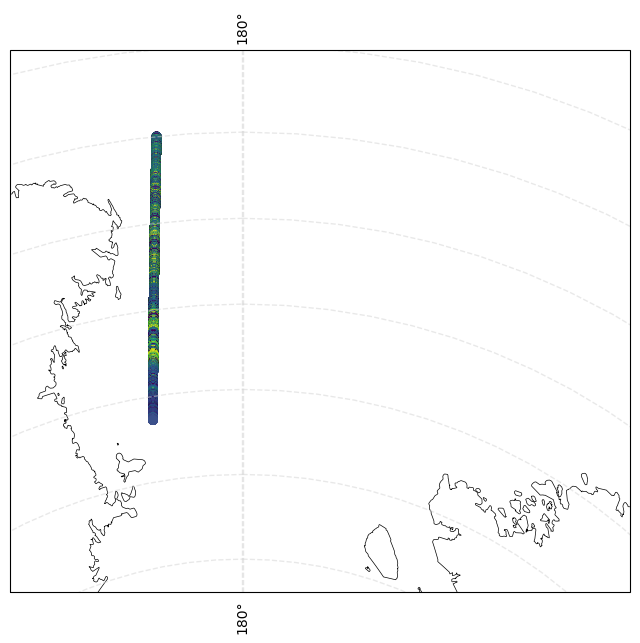

In [36]:
# Assign crs information into geodatafraem

fig=plt.figure(figsize=(8, 8), dpi = 100)
ax = plt.axes(projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70))

for df in track[:1]:
    # Convert crs of the geodataframe into the crs of the Sentinel-2 image
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

    gdf = gdf.to_crs(3412)

    gdf.x = [x for x in gdf.geometry.x]
    gdf.y = [y for y in gdf.geometry.y]


    # Use the in-built northpolarstereo to visualize (true scale latitude is from NSIDC polar stereographic)
    
    ax.scatter(gdf.x, gdf.y, c=gdf.freeboard, vmin=0, vmax = 0.4)
# pm = gdf.plot(ax=ax, c=gdf.freeboard, vmin=0, vmax = 0.1)
# pm  = ax.scatter(gdf.lon, gdf.lat)
ax.coastlines('10m', linewidth = 0.5) # add coastline
# Add gridline
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='lightgrey', alpha=0.5, linestyle='--')

# clb = plt.colorbar(pm, ax = ax, shrink = 0.4)
# clb.set_label('Sea ice freeboard (m)', rotation = 270, fontsize = 11, va = 'bottom')

ax.set_xlim(-3000000, 3000000)
ax.set_ylim(-3000000, 3000000)


xmin, xmax = ax.set_xlim(600000, -1000000)
ymin, ymax = ax.set_ylim(-1000000, -2400000);

# ax.set_xlim(-200, -150)
# ax.set_ylim(-80, -70)

In [20]:
# File name of the downloaded Sentinel-2 image
tutorial_data = "D:\\Ross\\S1B_EW_GRDM_1SDH_20190824T104432_20190824T104536_017726_02159D_C9CE.SAFE\\measurement"
img_name = f"{tutorial_data}\\s1b-ew-grd-hh-20190824t104432-20190824t104536-017726-02159d-001.tiff"

In [151]:
is2_data = glob.glob("ATL10/*.h5")
for i, f in enumerate(is2_data):
    print(i, f)

0 ATL10\ATL10-02_20190908114931_11060401_005_02.h5
1 ATL10\ATL10-02_20190908224932_11130401_005_02.h5
2 ATL10\ATL10-02_20190929104215_00390501_005_02.h5
3 ATL10\ATL10-02_20190929214217_00460501_005_02.h5
4 ATL10\ATL10-02_20200803200058_06030801_005_02.h5
5 ATL10\ATL10-02_20200807195237_06640801_005_02.h5
6 ATL10\ATL10-02_20200904044543_10820801_005_02.h5
7 ATL10\ATL10-02_20200910052023_11740801_005_02.h5
8 ATL10\ATL10-02_20200910175442_11820801_005_02.h5
9 ATL10\ATL10-02_20200912042904_12040801_005_02.h5
10 ATL10\ATL10-02_20200918173802_13040801_005_02.h5
11 ATL10\ATL10-02_20200927042126_00460901_005_02.h5
12 ATL10\ATL10-02_20200928163005_00690901_005_02.h5
13 ATL10\ATL10-02_20210802024023_06031201_005_01.h5
14 ATL10\ATL10-02_20210815124949_08081201_005_01.h5
15 ATL10\ATL10-02_20210819014128_08621201_005_01.h5
16 ATL10\ATL10-02_20210819124130_08691201_005_01.h5
17 ATL10\ATL10-02_20210820011549_08771201_005_01.h5
18 ATL10\ATL10-02_20210823013309_09231201_005_01.h5
19 ATL10\ATL10-02_2021

In [146]:
print(len(is2_data))

29


In [124]:
is2_data[19]

'ATL10\\ATL10-02_20210820121550_08841201_005_01.h5'

In [180]:
is2_file

'ATL10\\ATL10-02_20210904120811_11131201_005_01.h5'

ATL10\ATL10-02_20210913112554_12501201_005_01.h5 S1/S1_2021-09-13.tiff


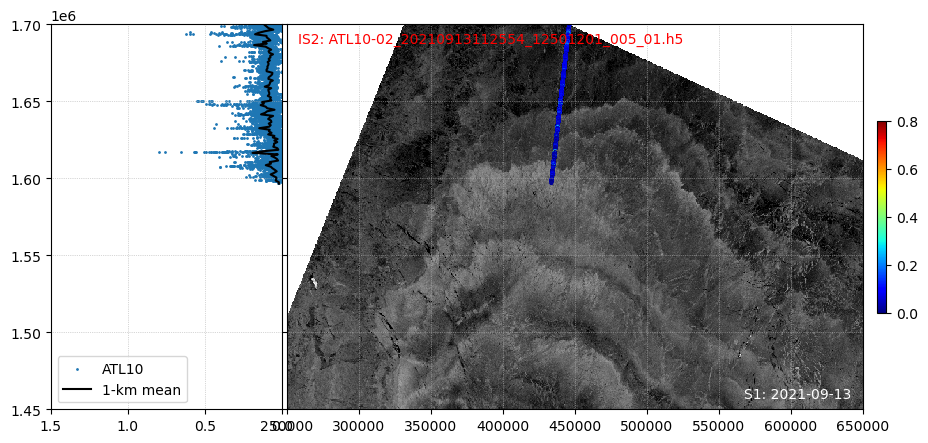

In [191]:
bb = [170, -78, -170, -70]

is2_file = is2_data[25]


track = read_atl10(is2_file, bb)
df = track[2]
is2date = datetime.strptime(os.path.basename(is2_file)[9:17], "%Y%m%d")
s1date = is2date.strftime("%Y-%m-%d")
s1date0 = (is2date - timedelta(days=1)).strftime("%Y-%m-%d")
s1date2 = (is2date + timedelta(days=1)).strftime("%Y-%m-%d")

if os.path.exists(f"S1/S1_{s1date}.tiff"):
    s1_file = f"S1/S1_{s1date}.tiff"
elif os.path.exists(f"S1/S1_{s1date2}.tiff"):
    s1_file = f"S1/S1_{s1date2}.tiff"
elif os.path.exists(f"S1/S1_{s1date0}.tiff"):
    s1_file = f"S1/S1_{s1date0}.tiff"

else:
    s1_file == None

if s1_file != None:
    print(is2_file, s1_file)
    # Read Sentinel-2 image using raterio
    with rasterio.open(s1_file) as img:
        array = img.read(1)

        height = array.shape[0]
        width = array.shape[1]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))

        # XY projected coordinate of the image
        xs, ys = rasterio.transform.xy(img.transform, rows, cols)
        xs = np.array(xs)
        ys = np.array(ys)

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
        gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

        gdf = gdf.to_crs(img.crs)
        gdf['x'] = gdf.geometry.apply(lambda x: x.x)
        gdf['y'] = gdf.geometry.apply(lambda x: x.y)

        gdf.x = [x for x in gdf.geometry.x]
        gdf.y = [y for y in gdf.geometry.y]

        # Boundary of the image
        x_min = xs.min()
        x_max = xs.max()
        y_min = ys.min()
        y_max = ys.max()

        # Clip geodataframe fitting to the image extent
        gdf2 = gdf[(gdf["x"]>=x_min) & (gdf["x"]<=x_max) & (gdf["y"]>=y_min) & (gdf["y"]<=y_max)].reset_index(drop=True)

        fig,ax = plt.subplots(1,2,figsize = (12,5), gridspec_kw={'width_ratios': [1, 3]}, sharey = True)
        plt.subplots_adjust(wspace=0.01)
        ax[1].pcolormesh(xs, ys, array, vmin = -20, vmax = 0, cmap = "gray")            
        sc = ax[1].scatter(gdf2['x'], gdf2['y'], c = gdf2['freeboard'], s = 3, vmin = 0, vmax = 0.8, cmap = "jet")
        fig.colorbar(sc, ax = ax[1], orientation = "vertical", shrink = 0.5, pad = 0.02)
        ax[1].grid(ls = ":", lw = 0.5)
        x_min, x_max = ax[1].set_xlim(250000, 650000)
        # x_min, x_max = ax[1].set_xlim(450000, 750000)
        # y_min, y_max = ax[1].set_ylim(1400000, 1650000)
        y_min, y_max = ax[1].set_ylim(1450000, 1700000)

        sample = pd.DataFrame({})
        sample_len = 1000
        i = 0
        for L in np.arange(y_min-sample_len, y_max+sample_len, sample_len):
            sample.loc[i, "y"] = L+sample_len/2
            sample.loc[i, "freeboard"] = gdf[(gdf.y>=L) & (gdf.y<L+sample_len)]["freeboard"].mean()
            i += 1

        ax[0].scatter(gdf2.freeboard, gdf2.y, s=1, label = "ATL10")
        ax[0].plot(sample.freeboard, sample.y, color = "k", label = "1-km mean")
        ax[0].set_xlim(0, 1.5)
        ax[0].invert_xaxis()
        ax[0].grid(ls = ":", lw = 0.5)
        ax[0].legend()
        ax[1].annotate(f"IS2: {is2_file[6:]}", xy=(0.02, 0.98), xycoords='axes fraction', fontsize=10, ha='left', va='top', color = "r")
        ax[1].annotate(f"S1: {s1_file[6:-5]}", xy=(0.98, 0.02), xycoords='axes fraction', fontsize=10, ha='right', va='bottom', color = "white")

        img_name = os.path.basename(is2_file).replace(".h5", ".png")
        plt.savefig(f"Figures/Image_{img_name}", bbox_inches = "tight")
        # plt.close()

else:
    print("No valid S1 image!")

In [87]:
os.path.basename(is2_file).replace(".h5", ".png")

'ATL10-02_20190908114931_11060401_005_02.png'

In [76]:
sample = pd.DataFrame({})
sample_len = 1000
i = 0
for L in np.arange(y_min-sample_len, y_max+sample_len, sample_len):
    sample.loc[i, "y"] = L+sample_len/2
    sample.loc[i, "freeboard"] = gdf[(gdf.y>=L) & (gdf.y<L+sample_len)]["freeboard"].mean()
    i += 1

In [77]:
sample

,y,freeboard
0,1399500.0,NaN
1,1400500.0,NaN
2,1401500.0,NaN
3,1402500.0,NaN
4,1403500.0,NaN
...,...,...
247,1646500.0,0.270541
248,1647500.0,0.166102
249,1648500.0,0.199802
250,1649500.0,0.218089


In [98]:
# File name of the downloaded Sentinel-2 image
tutorial_data = "C:\\Users\\yok223\\Research\\RossSea"
img_name = f"{tutorial_data}\\S1_2019-09-05.tiff"

In [102]:
# Read Sentinel-2 image using raterio
img = rasterio.open(img_name)
array = img.read(1)

height = array.shape[0]
width = array.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))

# XY projected coordinate of the image
xs, ys = rasterio.transform.xy(img.transform, rows, cols)
xs = np.array(xs)
ys = np.array(ys)

gdf2 = gdf.to_crs(img.crs)
gdf2['x'] = gdf2.geometry.apply(lambda x: x.x)
gdf2['y'] = gdf2.geometry.apply(lambda x: x.y)

# Boundary of the image
x_min = xs.min()
x_max = xs.max()
y_min = ys.min()
y_max = ys.max()

# Clip geodataframe fitting to the image extent
gdf2 = gdf2[(gdf2["x"]>=x_min) & (gdf2["x"]<=x_max) & (gdf2["y"]>=y_min) & (gdf2["y"]<=y_max)].reset_index(drop=True)
# img.close()

(1400000.0, 1640000.0)

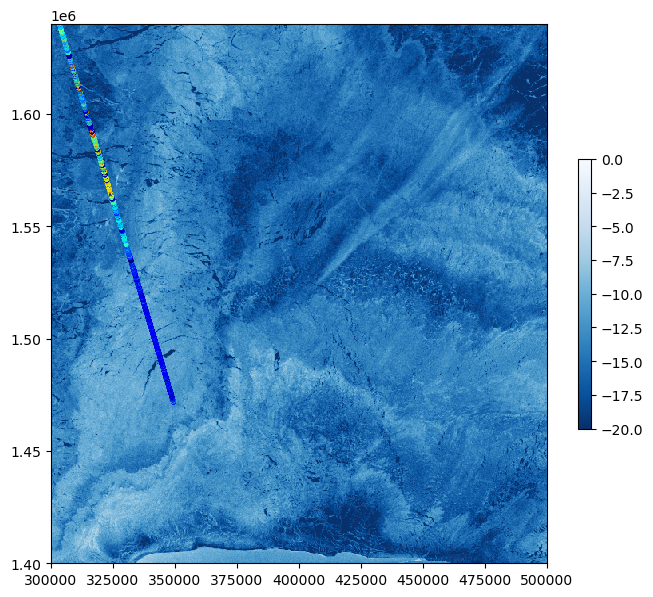

In [112]:
plt.figure(figsize = (8,7))
plt.pcolormesh(xs, ys, array, vmin = -20, vmax = 0, cmap = "Blues_r")
plt.colorbar(shrink = 0.5)
plt.scatter(gdf2['x'], gdf2['y'], c = gdf2['freeboard'], s = 5, vmin = 0, vmax = 0.8, cmap = "jet")
plt.xlim(300000, 500000)
plt.ylim(1400000, 1640000)

(1500000.0, 1630000.0)

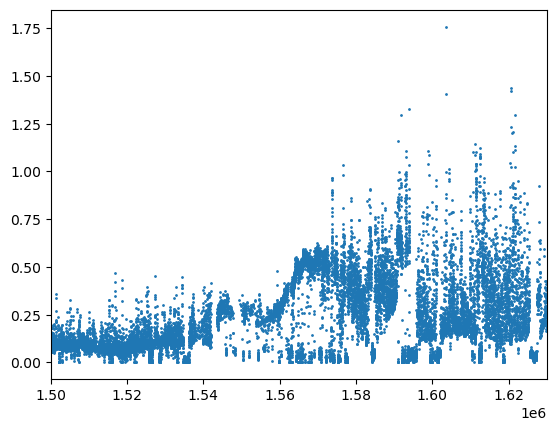

In [114]:
plt.scatter(gdf2['y'], gdf2['freeboard'], s=1)
plt.xlim(1500000, 1630000)

In [22]:
lon, lat = img.transform * (100, 100)

In [24]:
def LatLon_from_XY(ProductSceneGeoCoding, x, y):
    #From x,y position in satellite image (SAR), get the Latitude and Longitude
    geopos = ProductSceneGeoCoding.getGeoPos(PixelPos(x, y), None)
    latitude = geopos.getLat()
    longitude = geopos.getLon()
    return latitude, longitude

array([[5.00000e-01, 1.50000e+00, 2.50000e+00, ..., 1.03315e+04,
        1.03325e+04, 1.03335e+04],
       [5.00000e-01, 1.50000e+00, 2.50000e+00, ..., 1.03315e+04,
        1.03325e+04, 1.03335e+04],
       [5.00000e-01, 1.50000e+00, 2.50000e+00, ..., 1.03315e+04,
        1.03325e+04, 1.03335e+04],
       ...,
       [5.00000e-01, 1.50000e+00, 2.50000e+00, ..., 1.03315e+04,
        1.03325e+04, 1.03335e+04],
       [5.00000e-01, 1.50000e+00, 2.50000e+00, ..., 1.03315e+04,
        1.03325e+04, 1.03335e+04],
       [5.00000e-01, 1.50000e+00, 2.50000e+00, ..., 1.03315e+04,
        1.03325e+04, 1.03335e+04]])

In [27]:
import xarray as xr
slc_sm_path = "D:\\Ross\\S1B_EW_GRDM_1SDH_20190824T104432_20190824T104536_017726_02159D_C9CE.SAFE"
X = xr.open_dataset(slc_sm_path, engine="sentinel-1")

In [34]:
gcp.measurement.geospatial_bounds

'POLYGON((-179.0256310578334 -79.45432448344653,163.1438967539826 -77.69543730853954,171.0476294779512 -74.50879976948463,-174.4392024313815 -75.88129870814721,-179.0256310578334 -79.45432448344653))'

In [29]:
gcp = xr.open_dataset(
    slc_sm_path, engine="sentinel-1", group=f"EW/HH"
)
gcp

<xarray.Dataset>
Dimensions:       (ground_range: 10334, azimuth_time: 10861)
Coordinates:
    pixel         (ground_range) int32 ...
    line          (azimuth_time) int32 ...
  * azimuth_time  (azimuth_time) datetime64[ns] 2019-08-24T10:44:32.429915 .....
  * ground_range  (ground_range) float64 0.0 40.0 80.0 ... 4.133e+05 4.133e+05
Data variables:
    measurement   (azimuth_time, ground_range) float32 ...
Attributes: (12/30)
    family_name:                         SENTINEL-1
    number:                              B
    mode:                                EW
    swaths:                              ['EW']
    orbit_number:                        17726
    relative_orbit_number:               25
    ...                                  ...
    geospatial_lon_min:                  -179.0256310578334
    geospatial_lon_max:                  171.0476294779512
    group:                               /EW/HH
    subgroups:                           ['orbit', 'attitude', 'azimuth_fm_ra...
    Conventions:                         CF-1.8
    history:                             created by xarray_sentinel-0.9.5

In [30]:
gcp.plot.scatter(x="longitude", y="latitude", hue="height")

KeyError: 'latitude'

In [11]:
slc_s3_vh = xr.open_dataset(slc_sm_path, group="EW/HH", engine="sentinel-1", chunks=2048)
slc_s3_vh

<xarray.Dataset>
Dimensions:       (ground_range: 10334, azimuth_time: 10861)
Coordinates:
    pixel         (ground_range) int32 dask.array<chunksize=(2048,), meta=np.ndarray>
    line          (azimuth_time) int32 dask.array<chunksize=(2048,), meta=np.ndarray>
  * azimuth_time  (azimuth_time) datetime64[ns] 2019-08-24T10:44:32.429915 .....
  * ground_range  (ground_range) float64 0.0 40.0 80.0 ... 4.133e+05 4.133e+05
Data variables:
    measurement   (azimuth_time, ground_range) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
Attributes: (12/30)
    family_name:                         SENTINEL-1
    number:                              B
    mode:                                EW
    swaths:                              ['EW']
    orbit_number:                        17726
    relative_orbit_number:               25
    ...                                  ...
    geospatial_lon_min:                  -179.0256310578334
    geospatial_lon_max:                  171.0476294779512
    group:                               /EW/HH
    subgroups:                           ['orbit', 'attitude', 'azimuth_fm_ra...
    Conventions:                         CF-1.8
    history:                             created by xarray_sentinel-0.9.5

In [18]:
slc_s3_vh.measurement

<xarray.DataArray 'measurement' (azimuth_time: 10861, ground_range: 10334)>
dask.array<open_dataset-measurement, shape=(10861, 10334), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    pixel         (ground_range) int32 dask.array<chunksize=(2048,), meta=np.ndarray>
    line          (azimuth_time) int32 dask.array<chunksize=(2048,), meta=np.ndarray>
  * azimuth_time  (azimuth_time) datetime64[ns] 2019-08-24T10:44:32.429915 .....
  * ground_range  (ground_range) float64 0.0 40.0 80.0 ... 4.133e+05 4.133e+05
Attributes: (12/32)
    AREA_OR_POINT:                       Area
    TIFFTAG_DATETIME:                    2019:08:24 12:07:22
    TIFFTAG_IMAGEDESCRIPTION:            Sentinel-1A EW GRD MR L1
    TIFFTAG_SOFTWARE:                    Sentinel-1 IPF 003.10
    family_name:                         SENTINEL-1
    number:                              B
    ...                                  ...
    geospatial_lat_min:                  -79.45432448344653
    geospatial_lat_max:                  -74.50879976948463
    geospatial_lon_min:                  -179.0256310578334
    geospatial_lon_max:                  171.0476294779512
    units:                               1
    long_name:                           digital number

In [16]:
A = np.array(slc_s3_vh.measurement)

In [17]:
A

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0., 1730., 1847., ...,    0.,    0.,    0.],
       [   0., 1934., 1953., ...,    0.,    0.,    0.],
       [   0., 2045., 2003., ...,    0.,    0.,    0.]], dtype=float32)

In [ ]:
plt.figure(figsize = (8,7))
plt.pcolormesh(xs, ys, array, vmin = 0, vmax = 10000, cmap = "Blues_r")
plt.colorbar(shrink = 0.5)
plt.scatter(gdf['x'], gdf['y'], c = gdf['type'], s = 5, vmin = 0, vmax = 2, cmap = "jet")

(-77.0, -75.0)

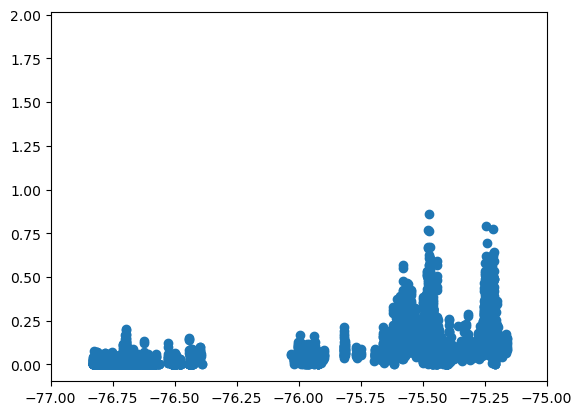

In [80]:
plt.scatter(df['lat'], df['freeboard'])
plt.xlim(-77, -75)

In [48]:
bound = ee.Geometry.Rectangle(bb);
Map = geemap.Map()

track_coord = list(zip([x for x in gdf.lon[::100]], [x for x in gdf.lat[::100]])) 
feature_track = ee.FeatureCollection(ee.Geometry.LineString(coords=track_coord, proj='EPSG:4326', geodesic=True)) 

S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))\
.filterDate('2019-08-22', '2019-08-23')\
.filterBounds(feature_track);


#.filterDate(date_range[0], date_range[1])\

bands = ['HH'];
img = S1.mean().select(bands);
img = ee.Image("COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20190822T110046_20190822T110150_017697_0214BA_5791").select(bands);

# Map.add_gdf(gdf)
Map.addLayer(img, {'min': -30, 'max': 0}, "S1 SAR")
Map.addLayer(feature_track, {}, "IS2 track")

Map.centerObject(bound, zoom = 5)
# Map.addLayer(feature_track, {}, "IS2 track")
Map

Map(center=[-73.9083210897887, -180], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=H…

In [52]:
geemap.download_ee_image(img, f"S2_2019-08-22.tif", scale=2000)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\yok223\anaconda3\envs\mygpu\lib\site-packages\geemap\common.py", line 12583, in download_ee_image
    import geedim as gd
ModuleNotFoundError: No module named 'geedim'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\yok223\anaconda3\envs\mygpu\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\yok223\AppData\Local\Temp\ipykernel_10484\3261733197.py", line 1, in <module>
    geemap.download_ee_image(img, f"S2_2019-08-22.tif", scale=2000)
  File "C:\Users\yok223\anaconda3\envs\mygpu\lib\site-packages\geemap\common.py", line 12585, in download_ee_image
    raise ImportError(
ImportError: Please install geedim using `pip install geedim` or `conda install -c conda-forge geedim`

During handling of the above exception, another exception occurred:

Traceback (most recent cal

In [58]:
downloadURL = img.getDownloadUrl({'name': 'S1_2019-08-22',
                                          'crs': img.projection().crs(),
                                          'scale': 400,
                                          'filePerBand': False,
                                          'format': 'GEO_TIFF'})
downloadURL

'https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/63966182df659ff907d79ee3753b92ea-3a57c4f0de74c01a95a7044b6ca89a14:getPixels'

In [ ]:
geemap.download_ee_image(img, f"S2_{img_name}.tif", scale=50)

## &#x2705; Explore ATL10 sea ice freeboard product (single track)

Now, we will explore what the ATL10 sea ice freeboard data really looks like. Let's start with the two example tracks in the Ross Sea, Antarctica.

### Import necessary libraries

### Read first track

#### Read local downloaded files

In [ ]:
## IF you want to access local downloaded files, please use the below codes.
# H5 file of the ATL10 track
tutorial_data = "/home/jovyan/shared-public/ICESat-2-Hackweek/sea_ice"
filename = f"{tutorial_data}/processed_ATL10-02_20190916205836_12340401_006_02.h5"
filename

#### Read cloud files

In [9]:
## IF you want to access the file via S3 bucket, please use the below codes.
s3 = earthaccess.get_s3fs_session(daac='NSIDC')
filename = s3.open(s3links[0], 'rb')
filename

NameError: name 's3links' is not defined

In [22]:
# Check the orbit orientation
with h5py.File(filename,'r') as f:
    orient = f['orbit_info/sc_orient'][0]

# 0: backward; 1: forward; 2: transition (do not use)
print(orient)

1


#### &#x1F50D; Which beam is strong/weak?

The relative location of strong and beak beams depends on the orientation of the satellite orbit. If the satellite moves in forward direction, right beams (i.e., GT1R, GT2R, GT3R) are STRONG beams. On the contrary, in the case of backward direction, left beams (i.e., GT1L, GT2L, GT3L) are WEAK beams.

```{figure} https://agupubs.onlinelibrary.wiley.com/cms/asset/9e074a72-2eb9-4457-b6ad-5c57d5334ee5/jgrc23628-fig-0001-m.jpg
:name: ICESat-2 orbit orientation

Orbit orientation and strong/weak beam of ICESat-2 (source: [Kwok et al. 2019](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019JC015486))
```


In [10]:
## Function to read ATL10 data
def read_atl10(filename, spatial_extent):

    # Create a list for saving ATL10 beam track data
    track = []

    with h5py.File(filename,'r') as f:

        # Check the orbit orientation
        orient = f['orbit_info/sc_orient'][0]

        if orient == 0:
            strong_beams = [f"gt{i}l" for i in [1, 2, 3]]
        elif orient == 1:
            strong_beams = [f"gt{i}r" for i in [1, 2, 3]]
        else:
            strong_beams = []

        for beam in strong_beams:
            # Version 5
            lat = f[beam]['freeboard_beam_segment/beam_freeboard/latitude'][:]
            lon = f[beam]['freeboard_beam_segment/beam_freeboard/longitude'][:]
            seg_x = f[beam]['freeboard_beam_segment/beam_freeboard/seg_dist_x'][:] / 1000 # (m to km)
            seg_len = f[beam]['freeboard_beam_segment/height_segments/height_segment_length_seg'][:]
            fb = f[beam]['freeboard_beam_segment/beam_freeboard/beam_fb_height'][:]
            surface_type = f[beam]['freeboard_beam_segment/height_segments/height_segment_type'][:]
            
            # lat = f[beam]['freeboard_segment/latitude'][:]
            # lon = f[beam]['freeboard_segment/longitude'][:]
            # seg_x = f[beam]['freeboard_segment/seg_dist_x'][:] / 1000 # (m to km)
            # seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][:]
            # fb = f[beam]['freeboard_segment/beam_fb_height'][:]
            # surface_type = f[beam]['freeboard_segment/heights/height_segment_type'][:]
            fb[fb>100] = np.nan

            df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len,
                              'freeboard': fb, 'stype': surface_type})

            df = df[(df['lat'] > spatial_extent[1]) & (df['lat'] < spatial_extent[3])].reset_index(drop=True)

            df['beam'] = beam
            df = df.dropna().reset_index(drop = True)

            track.append(df)
            
    return track

In [87]:
track = read_atl10(filename, spatial_extent)

### Draw freeboard track

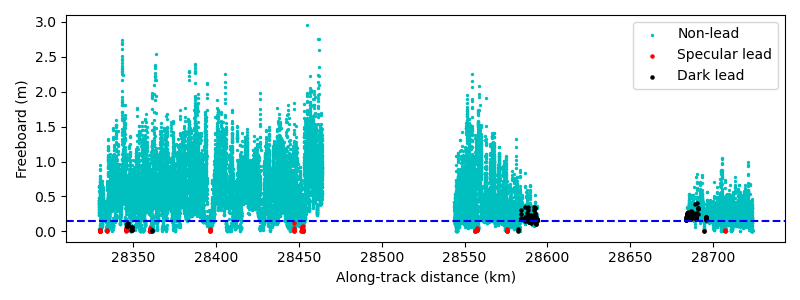

In [25]:
# Select which beam you want to explore (0, 1, 2)
df = track[0]

plt.figure(figsize = (8, 3))

# Masking for normal sea ice
mask_ice = (df.stype == 1)

# Masking for specular lead
mask_specular = (df.stype >= 2) & (df.stype <= 5)

# Masking for dark lead
mask_dark = (df.stype >= 6) & (df.stype <= 9)

plt.scatter(df.seg_x[mask_ice], df.freeboard[mask_ice], s = 2, color = "c", label = "Non-lead")
plt.scatter(df.seg_x[mask_specular], df.freeboard[mask_specular], s = 5, color = "r", label = "Specular lead")
plt.scatter(df.seg_x[mask_dark], df.freeboard[mask_dark], s = 5, color = "k", label = "Dark lead")
plt.axhline(0.15, color = "b", ls = "--")
plt.xlabel("Along-track distance (km)")
plt.ylabel("Freeboard (m)")
plt.legend()

# plt.xlim(32890, 32920)
plt.tight_layout()

In [26]:
## Calculate lead fraction
print("Sea ice (%): ", np.sum(df.seg_len[mask_ice]) / np.sum(df.seg_len) * 100)
print("Specular lead (%): ", np.sum(df.seg_len[mask_specular]) / np.sum(df.seg_len) * 100)
print("Dark lead (%): ", np.sum(df.seg_len[mask_dark]) / np.sum(df.seg_len) * 100)
print("Freeboard < 0.1 m (%): ", np.sum(df.seg_len[df.freeboard < 0.1]) / np.sum(df.seg_len) * 100)

Sea ice (%):  97.82050251960754
Specular lead (%):  0.16137033235281706
Dark lead (%):  2.018122561275959
Freeboard < 0.1 m (%):  6.698114424943924


### Draw freeboard histograms

Beam gt1r
   - mean freeboard: 0.504 m
   - std. dev. freeboard: 0.360 m
Beam gt2r
   - mean freeboard: 0.515 m
   - std. dev. freeboard: 0.387 m
Beam gt3r
   - mean freeboard: 0.506 m
   - std. dev. freeboard: 0.396 m


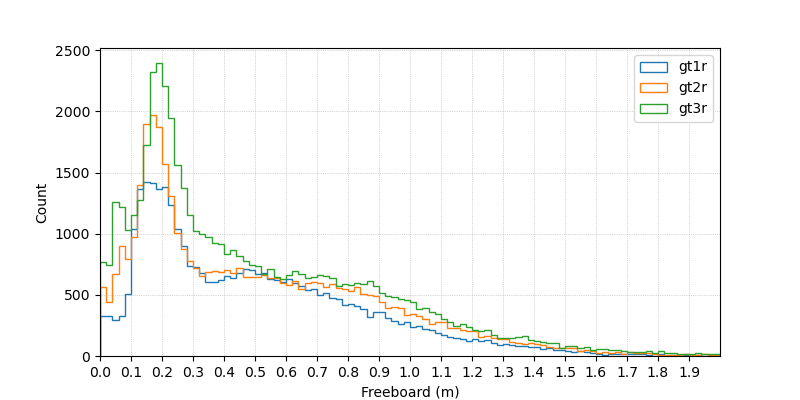

In [27]:
plt.figure(figsize = (8, 4))
for df in track:
    
    plt.hist(df['freeboard'], bins = 100, range = (0,2), label = df.beam[0], histtype = 'step')
    print(f"Beam {df.beam[0]}")
    print(f"   - mean freeboard: {df.freeboard.mean():.3f} m")
    print(f"   - std. dev. freeboard: {df.freeboard.std():.3f} m")
    
plt.xticks(np.arange(0,2,0.1))
plt.xlim(0,2)
plt.grid(ls = ":", lw = 0.5)
plt.legend()
plt.xlabel("Freeboard (m)")
plt.ylabel("Count")
plt.show()

## &#x1F4A1; Do it yourself!
Let's try the same steps for another track data for the Ross Sea Sea region. The first track we just examined is from September, but this second track is from November. Compare how the freeboard and lead fraction has been changed for these two months.

In [29]:
tutorial_data = "/home/jovyan/shared-public/ICESat-2-Hackweek/sea_ice"
filename = f"{tutorial_data}/processed_ATL10-02_20191113181045_07310501_006_01.h5"

In [30]:
track = read_atl10(filename, spatial_extent)

In [ ]:
# Plot lead fraction, floe size distribution, mean freeboard, etc.

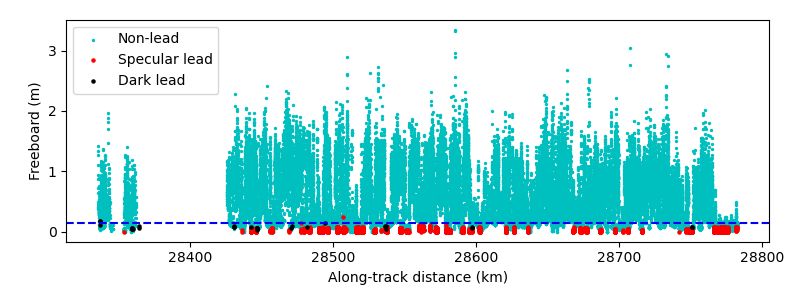

In [33]:
# Select which beam you want to explore (0, 1, 2)
df = track[2]

plt.figure(figsize = (8, 3))

# Masking for normal sea ice
mask_ice = (df.stype == 1)

# Masking for specular lead
mask_specular = (df.stype >= 2) & (df.stype <= 5)

# Masking for dark lead
mask_dark = (df.stype >= 6) & (df.stype <= 9)

plt.scatter(df.seg_x[mask_ice], df.freeboard[mask_ice], s = 2, color = "c", label = "Non-lead")
plt.scatter(df.seg_x[mask_specular], df.freeboard[mask_specular], s = 5, color = "r", label = "Specular lead")
plt.scatter(df.seg_x[mask_dark], df.freeboard[mask_dark], s = 5, color = "k", label = "Dark lead")
plt.axhline(0.15, color = "b", ls = "--")
plt.xlabel("Along-track distance (km)")
plt.ylabel("Freeboard (m)")
plt.legend()

# plt.xlim(32890, 32920)
plt.tight_layout()

Beam gt1r
   - mean freeboard: 0.501 m
   - std. dev. freeboard: 0.430 m
Beam gt2r
   - mean freeboard: 0.492 m
   - std. dev. freeboard: 0.430 m
Beam gt3r
   - mean freeboard: 0.510 m
   - std. dev. freeboard: 0.437 m


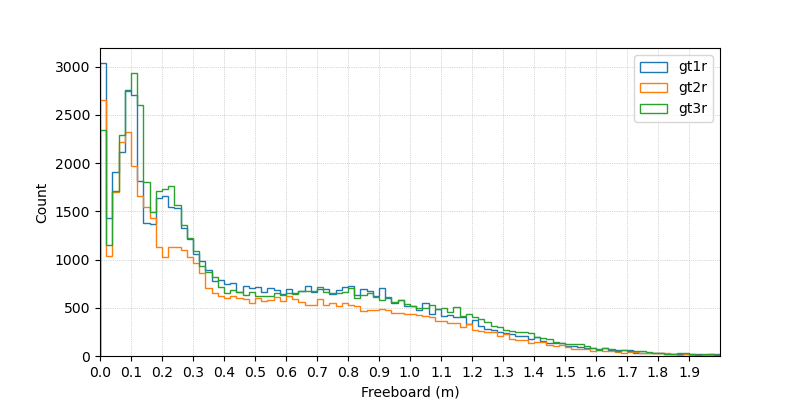

In [34]:
plt.figure(figsize = (8, 4))
for df in track:
    
    plt.hist(df['freeboard'], bins = 100, range = (0,2), label = df.beam[0], histtype = 'step')
    print(f"Beam {df.beam[0]}")
    print(f"   - mean freeboard: {df.freeboard.mean():.3f} m")
    print(f"   - std. dev. freeboard: {df.freeboard.std():.3f} m")
    
plt.xticks(np.arange(0,2,0.1))
plt.xlim(0,2)
plt.grid(ls = ":", lw = 0.5)
plt.legend()
plt.xlabel("Freeboard (m)")
plt.ylabel("Count")
plt.show()

## &#x2705; Explore sea ice freeboard products (gridded product)

Now we will explore gridded sea ice freeboard product (ATL20).

### Antarctic example

We will visualize the Antractic sea ice in September 2021. In general, the Antarctic sea ice extent reaches maximum in September, so you will be able to see the maximum sea ice extent.

In [42]:
# Query Antarctic ATL20 data using earthaccess (September)
Query = earthaccess.granule_query().concept_id(
    'C2153577387-NSIDC_CPRD'
).temporal("2021-09-01 T10:00:00", "2021-09-30 T23:00:00"
).bounding_box(-180, -90, 180, -60)

granules = Query.get()
granules

[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Daily and Monthly Gridded Sea Ice Freeboard V003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -179.999992, 'EastBoundingCoordinate': 179.999999, 'NorthBoundingCoordinate': -53.516075, 'SouthBoundingCoordinate': -78.481569}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-09-01T01:52:44.289Z', 'EndingDateTime': '2021-10-01T00:18:47.822Z'}}
 Size(MB): 2.6486663818359375
 Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL20/003/2021/ATL20-02_20210901005050_10601201_003_01.h5']]

In [43]:
# Open file
files = earthaccess.open(granules)
files[0]

 Opening 1 granules, approx size: 0.0 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL20/003/2021/ATL20-02_20210901005050_10601201_003_01.h5>

In [45]:
# Read h5 file
with h5py.File(files[0],'r') as f:
    print(f['daily']['day01'].keys())
    mean_fb = f['monthly']['mean_fb'][:]
    std_fb = f['monthly']['sigma'][:]
    mean_fb[mean_fb > 1000] = np.nan
    std_fb[mean_fb > 1000] = np.nan
    
    # ATL20 is 25 km grid data
    lat = f['grid_lat'][:] # Latitude
    lon = f['grid_lon'][:] # Longitude
    
    # Spatial reference: NSIDC Sea Ice Polar Stereographic South (EPSG:3412)
    x = f['grid_x'][:]
    y = f['grid_y'][:]
    xx, yy = np.meshgrid(x, y)

<KeysViewHDF5 ['delta_time_beg', 'delta_time_end', 'length_sum', 'mean_fb', 'n_segs', 'sigma']>


(-800000.0, -3200000.0)

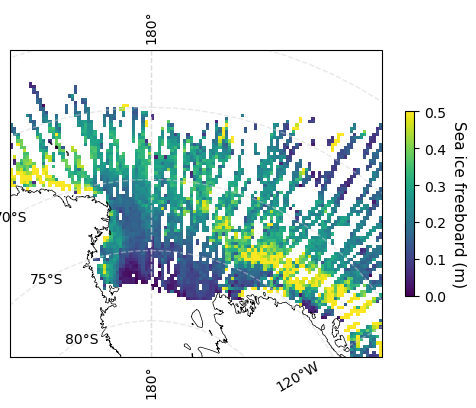

In [56]:
fig=plt.figure(figsize=(6, 6))

# Use the in-built northpolarstereo to visualize (true scale latitude is from NSIDC polar stereographic)
ax = plt.axes(projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70))

pm  = ax.pcolormesh(xx ,yy, mean_fb, vmin = 0, vmax = 0.5)
ax.coastlines('10m', linewidth = 0.5) # add coastline
# Add gridline
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='lightgrey', alpha=0.5, linestyle='--')

clb = plt.colorbar(pm, ax = ax, shrink = 0.4)
clb.set_label('Sea ice freeboard (m)', rotation = 270, fontsize = 11, va = 'bottom')

ax.set_xlim(1100000, -1800000)
ax.set_ylim(-800000, -3200000)

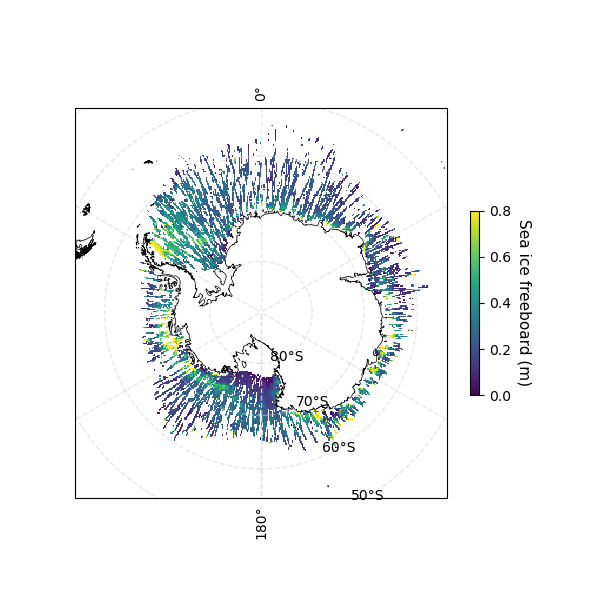

In [38]:
fig=plt.figure(figsize=(6, 6))

# Use the in-built northpolarstereo to visualize (true scale latitude is from NSIDC polar stereographic)
ax = plt.axes(projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70))

pm  = ax.pcolormesh(xx ,yy, mean_fb, vmin = 0, vmax = 0.8)
ax.coastlines('10m', linewidth = 0.5) # add coastline
# Add gridline
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='lightgrey', alpha=0.5, linestyle='--')

clb = plt.colorbar(pm, ax = ax, shrink = 0.4)
clb.set_label('Sea ice freeboard (m)', rotation = 270, fontsize = 11, va = 'bottom')
plt.show()

### Arctic example

For the Arctic, we will visualize sea ice freeboard map in March 2021.

In [39]:
Query = earthaccess.granule_query().concept_id(
    'C2153577387-NSIDC_CPRD'
).temporal("2021-03-01 T10:00:00", "2021-03-30 T23:00:00"
).bounding_box(-180, 60, 180, 90)

granules = Query.get()

files = earthaccess.open(granules)

with h5py.File(files[0],'r') as f:
    mean_fb = f['monthly']['mean_fb'][:]
    mean_fb[mean_fb > 1000] = np.nan

    lat = f['grid_lat'][:]
    lon = f['grid_lon'][:]
    
    # Spatial reference: NSIDC Sea Ice Polar Stereographic North (EPSG:3411)
    x = f['grid_x'][:]
    y = f['grid_y'][:]
    xx, yy = np.meshgrid(x, y)

 Opening 1 granules, approx size: 0.0 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

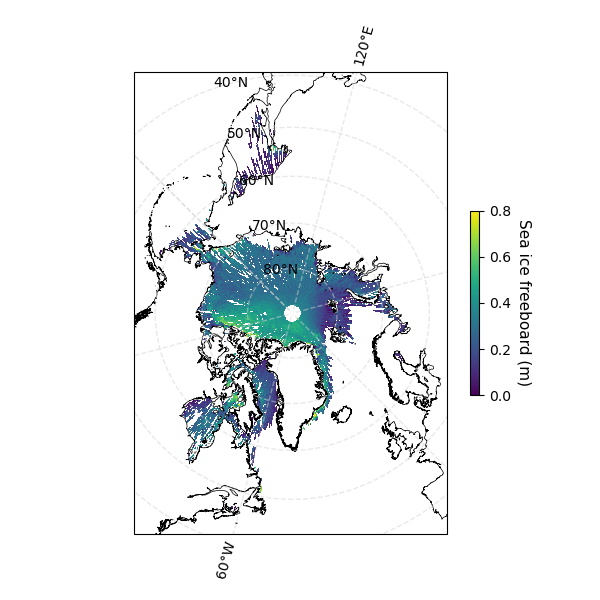

In [40]:
fig=plt.figure(figsize=(6, 6))
# Use the in-built northpolarstereo to visualize (true scale latitude is from NSIDC polar stereographic)
ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude = 70))

pm  = ax.pcolormesh(xx ,yy, mean_fb, vmin = 0, vmax = 0.8)
ax.coastlines('10m', linewidth = 0.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='lightgrey', alpha=0.5, linestyle='--')
clb = plt.colorbar(pm, ax = ax, shrink = 0.4)
clb.set_label('Sea ice freeboard (m)', rotation = 270, fontsize = 11, va = 'bottom')

## &#x1F4A1; Do it yourself!
Let's visualize the griddged freeboard for another month. 

In [41]:
Query = earthaccess.granule_query().concept_id(
    'C2153577387-NSIDC_CPRD'
).temporal("2021-08-01 T10:00:00", "2021-08-30 T23:00:00"
).bounding_box(-180, 60, 180, 90)

granules = Query.get()

files = earthaccess.open(granules)

with h5py.File(files[0],'r') as f:
    mean_fb = f['monthly']['mean_fb'][:]
    mean_fb[mean_fb > 1000] = np.nan

    lat = f['grid_lat'][:]
    lon = f['grid_lon'][:]
    
    # Spatial reference: NSIDC Sea Ice Polar Stereographic North (EPSG:3411)
    x = f['grid_x'][:]
    y = f['grid_y'][:]
    xx, yy = np.meshgrid(x, y)

 Opening 1 granules, approx size: 0.0 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

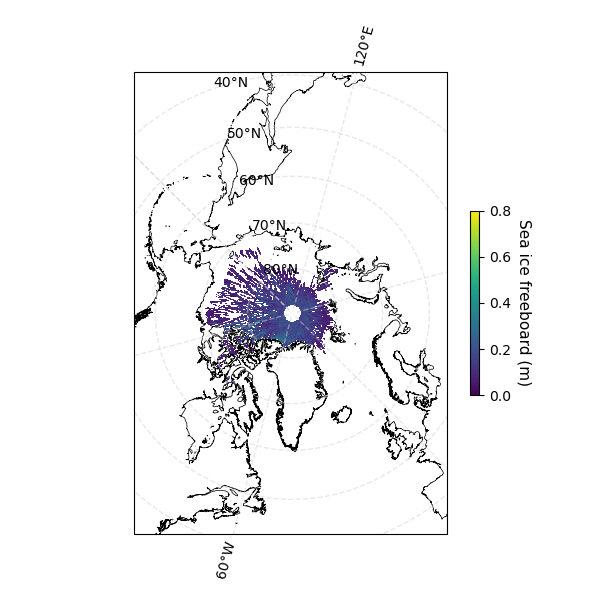

In [42]:
fig=plt.figure(figsize=(6, 6))
# Use the in-built northpolarstereo to visualize (true scale latitude is from NSIDC polar stereographic)
ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude = 70))

pm  = ax.pcolormesh(xx ,yy, mean_fb, vmin = 0, vmax = 0.8)
ax.coastlines('10m', linewidth = 0.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='lightgrey', alpha=0.5, linestyle='--')
clb = plt.colorbar(pm, ax = ax, shrink = 0.4)
clb.set_label('Sea ice freeboard (m)', rotation = 270, fontsize = 11, va = 'bottom')

## Helpful references

- Kwok, R., Markus, T., Kurtz, N. T., Petty, A. A., Neumann, T. A., Farrell, S. L., et al. (2019). Surface height and sea ice freeboard of the Arctic Ocean from ICESat-2: Characteristics and early results. Journal of Geophysical Research: Oceans, 124, 6942–6959. [LINK](https://doi.org/10.1029/2019JC015486)
- Petty, A. A., Bagnardi, M., Kurtz, N. T., Tilling, R., Fons, S., Armitage, T., et al. (2021). Assessment of ICESat-2 sea ice surface classification with Sentinel-2 imagery: Implications for freeboard and new estimates of lead and floe geometry. Earth and Space Science, 8, e2020EA001491. [LINK](https://doi.org/10.1029/2020EA001491)
- Petty, A. A., Kurtz, N. T., Kwok, R., Markus, T., & Neumann, T. A. (2020). Winter Arctic sea ice thickness from ICESat-2 freeboards. Journal of Geophysical Research: Oceans, 125, e2019JC015764. [LINK](https://doi.org/10.1029/2019JC015764)

**Credited by Younghyun Koo (kooala317@gmail.com)**